In [445]:
import cv2
from PIL import Image
import numpy as np  
import easyocr
import pytesseract
import pandas as pd
from matplotlib import pyplot as plt
from skimage.filters import threshold_niblack

In [446]:
img_path="passport/1.jpg"
image=cv2.imread(img_path)
max_h,max_w=image.shape[:2]

In [447]:
def display(im_path):
    dpi = 200
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

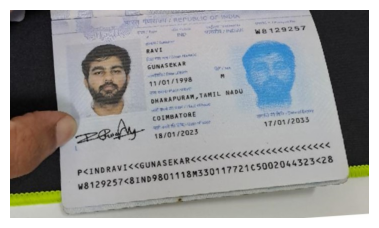

In [448]:
display("passport/1.jpg")

In [449]:
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
cv2.imwrite('temp_pass/gray.jpg',gray)
thresh=cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,8)
cv2.imwrite('temp_pass/thresh.jpg',thresh)
kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(12,15))
dilate=cv2.dilate(thresh,kernel,iterations=1)
cv2.imwrite('temp_pass/dilated.jpg',dilate)


True

In [450]:
def get_skew_angle(dilate):
    cnts= cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts=cnts[0] if len(cnts)==2 else cnts[1]
    cnts=sorted(cnts,key=lambda x: cv2.contourArea(x),reverse=True)
    copy_img=image.copy()
    for c in cnts:
       x,y,w,h=cv2.boundingRect(c)
       area=cv2.contourArea(c)
       if 70000>area>20000:
          rect=cv2.minAreaRect(c)
          box=cv2.boxPoints(rect)
          box=np.intp(box)
          contour_img=cv2.drawContours(copy_img,[box],0,(0,255,0),2)
          cv2.imwrite('temp_pass/contour.jpg',contour_img)
    largest_contour=cnts[1]
    print(len(largest_contour))    
    min_area_rect=cv2.minAreaRect(largest_contour)
    print(min_area_rect)
    angle=min_area_rect[-1]
    print(angle)
    if angle > 45:
        angle =-(angle-90)
    else:
        angle=angle
    print(angle)
    return -1.0 * (angle)

In [451]:
def rotate(image,angle):
    new_image=image.copy()
    h,w=new_image.shape[:2]  
    M=cv2.getRotationMatrix2D(((w-1)/2.0,(h-1)/2.0),angle,1.0)
    new_image=cv2.warpAffine(new_image,M,(w,h),flags=cv2.INTER_CUBIC,borderMode=cv2.BORDER_REPLICATE)
    return cv2.imwrite("temp_pass/rotated.jpg",new_image)

In [452]:
angle=get_skew_angle(dilate)
deskew=rotate(image,angle)

706
((373.6018981933594, 196.39073181152344), (331.7449645996094, 568.390625), 83.84162902832031)
83.84162902832031
6.1583709716796875


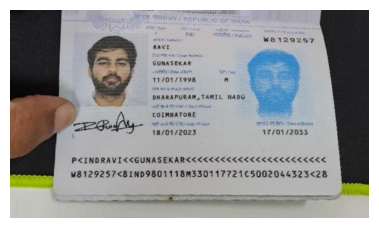

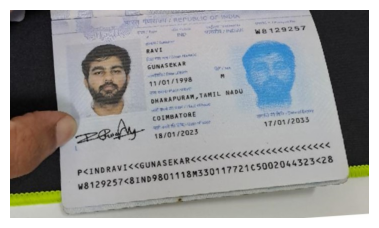

In [453]:
img=cv2.imread("temp_pass/rotated.jpg")
display("temp_pass/rotated.jpg")
display("passport/1.jpg")


In [454]:
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
cv2.imwrite('temp_pass/gray.jpg',gray)
thresh=cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,8)
cv2.imwrite('temp_pass/thresh.jpg',thresh)
kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(12,15))
dilate=cv2.dilate(thresh,kernel,iterations=1)
cv2.imwrite('temp_pass/dilated.jpg',dilate)

True

In [455]:
cnts= cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts=cnts[0] if len(cnts)==2 else cnts[1]
cnts=sorted(cnts,key=lambda x: cv2.contourArea(x),reverse=True)
base_img=img.copy()
for c in cnts:
    x,y,w,h=cv2.boundingRect(c)
    area=cv2.contourArea(c)
    if 70000>area>20000:
        rect=cv2.minAreaRect(c)
        box=cv2.boxPoints(rect)
        box=np.intp(box)
        contour_img=cv2.drawContours(base_img,[box],0,(0,255,0),2)
        roi=base_img[y:y+h,x:x+w]
        cv2.imwrite('temp_pass/roi.jpg',roi)
cv2.imwrite('temp_pass/contour.jpg',base_img)

True

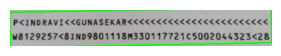

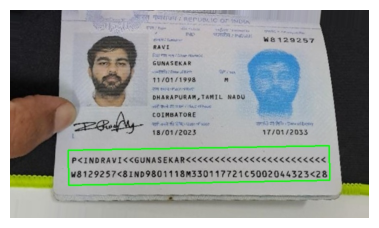

In [456]:
display("temp_pass/roi.jpg")
display("temp_pass/contour.jpg")

In [457]:
ocr_result=pytesseract.image_to_string(roi)
print(ocr_result)

P<INDRAVI<<GUNASEKARSKKKK KKK KKK KKK KKK KKK KKK
W8129257<81ND9801118M33011772105002044323<28



In [458]:
reader=easyocr.Reader(['en'], gpu=False)


Using CPU. Note: This module is much faster with a GPU.


In [459]:
results=reader.readtext(roi)
pd.DataFrame(results,columns=['bbox','text','conf'])

,bbox,text,conf
0,"[[3, 15], [516, 15], [516, 36], [3, 36]]",P<INDRAVI<<GUnASEKAR<<<<<<<<<<<<<<<<<<<<<<<<,0.151222
1,"[[2, 42], [522, 42], [522, 66], [2, 66]]",08129257<81ND9801118033011772105002044323<28,0.393576
